In [1]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 


line = xt.Line.from_json('sps.json')
particle_ref=line.particle_ref

line.build_tracker()
#line.freeze_longitudinal()
# line.optimize_for_tracking()

twiss=line.twiss()

clight=constants.speed_of_light
circumference = line.get_length()

#%%
###################
# Linear Transfer #
###################

qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
# beta_x=twiss['betx'][-1]
# beta_y=twiss['bety'][-1]

qs=twiss['qs']
bets=twiss['betz0']


#at interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
beta_x  =  54.614389 # m
beta_y  =  44.332517 # m
alpha_x = -1.535235
alpha_y =  1.314101



Dx  =  2.444732 # m
Dpx =  0.097522


Dy  =  0.0 # m
Dpy =  0.0

#index of gamma factory along SPS line: 16675

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        alfx=alpha_x,
        alfy=alpha_y,
        betx=beta_x,
        bety=beta_y,
        
        dx=Dx,
        dpx=Dpx,
        dy=Dy,
        dpy=Dpy,
        qs=qs,
        bets=bets,
        )


/home/pkruyt/cernbox/xsuite-laser/xtrack/xtrack/progress_indicator.py:90: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [2]:
from ion_properties import ions,lead,calcium,xenon

ion=calcium

In [3]:
# Ion properties:
q0 = ion.q0
mass0 = ion.mass0

gamma = ion.gamma_rel
beta= ion.beta_rel
p0c = mass0*gamma*beta #eV/c

bunch_intensity = ion.Intensity

particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0)

line.particle_ref=particle_ref


In [4]:
# # Source: https://www.sciencedirect.com/science/article/pii/S0146641020300399
# # Ion beam dimensions:
# sigma_x = 1.047e-3 # m
# sigma_y = 0.83e-3  # m
# sigma_z = 0.063 # m
# sigma_dp = 2e-4 # relative ion momentum spread

# sigma_px=4.36*1e-3 #calculated from the Twiss parameters
# sigma_py=4.36*1e-3 #calculated from the Twiss parameters

# num_particles = int(1e3)

# particles0 = xp.Particles(
#      mass0 = mass0, # eV/c^2
#      q0    = q0,
#      p0c   = p0c, # eV
#      x     = np.random.normal(scale=sigma_x, size=num_particles),
#      px    = np.random.normal(scale=sigma_px, size=num_particles),
#      y     = np.random.normal(scale=sigma_y, size=num_particles),
#      py    = np.random.normal(scale=sigma_py, size=num_particles),
#      zeta  = np.random.normal(scale=sigma_z, size=num_particles),
#      delta = np.random.normal(scale=sigma_dp, size=num_particles)
#         )

In [5]:
nemitt = 1.5e-6 # m*rad (normalized emittance)
sigma_z = 0.063 # m

emittance=nemitt/(beta*gamma)

num_particles=int(1e3)

line_arc=xt.Line(
        elements=[arc])
line_arc.build_tracker()

particles = xp.generate_matched_gaussian_bunch(
        num_particles=num_particles,
        total_intensity_particles=bunch_intensity,
        nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
        particle_ref=particle_ref,
        line=line_arc,        
        )

particles0=particles.copy()
# sigma_dp=2e-4  
sigma_dp=np.std(particles.delta)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [6]:
np.std(particles0.delta*1e4)

LinkedArrayCpu(0.97375456)

In [7]:
##################
# Laser Cooler #
##################

#laser-ion beam collision angle
theta_l = 2.6*np.pi/180 # rad
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

# Ion excitation energy:
ion_excited_lifetime=ion.excited_lifetime
hw0 = ion.hw0 # eV
hc=constants.hbar*clight/constants.e # eV*m (ħc)
lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

lambda_l = lambda_0*gamma*(1 + beta*np.cos(theta_l)) # m -- laser wavelength

# Shift laser wavelength for fast longitudinal cooling:5
lambda_l = lambda_l*(1+1*sigma_dp) # m

laser_frequency = clight/lambda_l # Hz
sigma_w = 2*np.pi*laser_frequency*sigma_dp
#sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

laser_waist_radius = 1.3e-3 #m
laser_energy = 5e-3

laser_x=-1*1e-3

GF_IP = xt.PulsedLaser(
                laser_x=laser_x,
                laser_y=0,
                laser_z=0,
                
                laser_direction_nx = 0,
                laser_direction_ny = ny,
                laser_direction_nz = nz,
                laser_energy         = laser_energy, # J
                laser_duration_sigma = sigma_t, # sec
                laser_wavelength = lambda_l, # m
                laser_waist_radius = laser_waist_radius, # m
                laser_waist_shift = 0, # m
                ion_excitation_energy = hw0, # eV
                ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                )

# simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
max_time_s = 10
int_time_s = 0.1
T_per_turn = circumference/(clight*beta)
num_turns = int(max_time_s/T_per_turn)
save_interval = int(int_time_s/T_per_turn)

# num_turns = int(1e3)
# save_interval = num_turns/100
# # save_interval=1

# create a monitor object, to reduce holded data
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                              n_repetitions=int(num_turns/save_interval),
                              repetition_period=save_interval,
                              num_particles=num_particles)


# line.discard_tracker()
# IP_index=16675   
# line.insert_element('monitor', element=monitor, index=IP_index)
# line.insert_element('GF_IP', element=GF_IP, index=IP_index) #this way monitor comes after the laser
# SPS_line.append_element(monitor,'monitor')
# SPS_line.append_element(GF_IP,'GF_IP')



Laser pulse duration sigma_t = 4.91 ps
Laser wavelength = 900.00 nm


In [8]:
laser_x_list=np.linspace(-5*1e-3,5*1e-3,100)
final_emittance_list = []
cooler_growth_rates_list=[]

from scipy.optimize import curve_fit

for laser_x_loop in tqdm(laser_x_list):
    
        GF_IP.laser_x=laser_x_loop
        particles=particles0.copy()

        line = xt.Line(
                elements=[monitor,GF_IP,arc])

        context = xo.ContextCpu(omp_num_threads=4)
        line.build_tracker(_context=context)
        # line.optimize_for_tracking()

        line.track(particles, num_turns=num_turns,
                turn_by_turn_monitor=False,with_progress=True)

        # extract relevant values
        x = monitor.x[:,:,0]
        px = monitor.px[:,:,0]
        y = monitor.y[:,:,0]
        py = monitor.py[:,:,0]
        delta = monitor.delta[:,:,0]
        zeta = monitor.zeta[:,:,0]
        state = monitor.state[:,:,0]
        time = monitor.at_turn[:, 0, 0] * T_per_turn

        gamma_x=(1+alpha_x**2)/beta_x
        gamma_y=(1+alpha_y**2)/beta_y

        action_x = (gamma_x*(x-Dx*delta)**2 + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta)+ beta_x*(px-Dpx*delta)**2)
        action_y = (gamma_y*(y-Dy*delta)**2 + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta)+ beta_y*(py-Dpy*delta)**2)

        emittance_x_twiss=np.mean(action_x,axis=1)*gamma/2

        # Define the exponential function
        def exponential_func(x, a, b):
                return a * np.exp(x * b)

        # Fit the data to the exponential function
        params, covariance = curve_fit(exponential_func, time, emittance_x_twiss)

        # Extract the parameters
        a, b = params

        # Generate the fitted curve
        fit_curve = exponential_func(time, a, b)

        final_emittance_list.append(emittance_x_twiss[-1])

        cooler_growth_rates_list.append(b)

np.savez(f'results/Optimal_laser_x_{ion.name}.npz', cooler_growth_rates_list=cooler_growth_rates_list,final_emittance_list=final_emittance_list,laser_x_list=laser_x_list,nemitt=nemitt,time=time)

  0%|          | 0/100 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

/home/pkruyt/miniforge3/envs/xsuite-laser/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  1%|          | 1/100 [02:34<4:15:28, 154.83s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  2%|▏         | 2/100 [05:10<4:13:21, 155.12s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  3%|▎         | 3/100 [07:56<4:18:59, 160.20s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  4%|▍         | 4/100 [10:54<4:27:35, 167.24s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  5%|▌         | 5/100 [14:02<4:36:45, 174.80s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  6%|▌         | 6/100 [17:21<4:46:27, 182.84s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  7%|▋         | 7/100 [20:48<4:55:36, 190.72s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  8%|▊         | 8/100 [24:14<5:00:10, 195.77s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  9%|▉         | 9/100 [28:09<5:15:17, 207.88s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 10%|█         | 10/100 [32:00<5:22:44, 215.16s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 11%|█         | 11/100 [35:58<5:29:35, 222.19s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [39:38<5:24:53, 221.51s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [43:27<5:24:17, 223.65s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [47:28<5:27:58, 228.82s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [51:36<5:32:25, 234.65s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [55:47<5:35:34, 239.70s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [1:00:08<5:40:22, 246.06s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [1:04:33<5:44:01, 251.72s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [1:09:12<5:50:56, 259.95s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 20%|██        | 20/100 [1:13:54<5:55:37, 266.71s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 21%|██        | 21/100 [1:18:34<5:56:13, 270.55s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [1:23:19<5:57:31, 275.02s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [1:28:26<6:05:14, 284.60s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [1:33:44<6:13:06, 294.56s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [1:39:09<6:19:40, 303.75s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [1:44:25<6:19:07, 307.40s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [1:49:51<6:20:36, 312.83s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [1:55:23<6:22:19, 318.61s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 29%|██▉       | 29/100 [2:00:53<6:21:17, 322.22s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 30%|███       | 30/100 [2:06:04<6:11:52, 318.75s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 31%|███       | 31/100 [2:11:08<6:01:33, 314.40s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 32%|███▏      | 32/100 [2:16:24<5:56:45, 314.79s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 33%|███▎      | 33/100 [2:21:40<5:51:45, 315.01s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 34%|███▍      | 34/100 [2:26:52<5:45:33, 314.14s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 35%|███▌      | 35/100 [2:32:02<5:39:04, 312.99s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 36%|███▌      | 36/100 [2:37:13<5:33:04, 312.26s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 37%|███▋      | 37/100 [2:42:23<5:27:16, 311.69s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 38%|███▊      | 38/100 [2:47:33<5:21:26, 311.07s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 39%|███▉      | 39/100 [2:52:51<5:18:28, 313.25s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 40%|████      | 40/100 [2:58:08<5:14:16, 314.27s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 41%|████      | 41/100 [3:03:30<5:11:30, 316.79s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 42%|████▏     | 42/100 [3:08:49<5:06:55, 317.50s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 43%|████▎     | 43/100 [3:14:00<4:59:33, 315.33s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 44%|████▍     | 44/100 [3:19:15<4:54:21, 315.38s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 45%|████▌     | 45/100 [3:24:23<4:47:03, 313.15s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 46%|████▌     | 46/100 [3:29:38<4:42:14, 313.61s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 47%|████▋     | 47/100 [3:34:56<4:38:19, 315.09s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 48%|████▊     | 48/100 [3:40:14<4:33:48, 315.94s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 49%|████▉     | 49/100 [3:45:41<4:31:21, 319.25s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 50%|█████     | 50/100 [3:50:50<4:23:28, 316.18s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 51%|█████     | 51/100 [3:56:08<4:18:38, 316.70s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 52%|█████▏    | 52/100 [4:01:14<4:10:47, 313.48s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 53%|█████▎    | 53/100 [4:06:19<4:03:38, 311.03s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 54%|█████▍    | 54/100 [4:11:34<3:59:19, 312.16s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 55%|█████▌    | 55/100 [4:16:48<3:54:34, 312.76s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 56%|█████▌    | 56/100 [4:22:03<3:49:53, 313.48s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 57%|█████▋    | 57/100 [4:27:15<3:44:18, 312.98s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 58%|█████▊    | 58/100 [4:32:16<3:36:34, 309.38s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 59%|█████▉    | 59/100 [4:37:30<3:32:12, 310.55s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 60%|██████    | 60/100 [4:42:31<3:25:08, 307.71s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 61%|██████    | 61/100 [4:47:35<3:19:24, 306.79s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 62%|██████▏   | 62/100 [4:52:39<3:13:41, 305.82s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 63%|██████▎   | 63/100 [4:57:41<3:07:53, 304.70s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 64%|██████▍   | 64/100 [5:02:52<3:03:54, 306.51s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 65%|██████▌   | 65/100 [5:07:54<2:57:58, 305.10s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 66%|██████▌   | 66/100 [5:13:01<2:53:20, 305.90s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 67%|██████▋   | 67/100 [5:18:09<2:48:30, 306.39s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 68%|██████▊   | 68/100 [5:23:21<2:44:15, 307.99s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 69%|██████▉   | 69/100 [5:28:10<2:36:13, 302.37s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 70%|███████   | 70/100 [5:33:15<2:31:34, 303.16s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 71%|███████   | 71/100 [5:38:26<2:27:39, 305.49s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 72%|███████▏  | 72/100 [5:43:29<2:22:18, 304.94s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 73%|███████▎  | 73/100 [5:48:31<2:16:43, 303.84s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 74%|███████▍  | 74/100 [5:53:26<2:10:34, 301.33s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 75%|███████▌  | 75/100 [5:58:22<2:04:53, 299.76s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 76%|███████▌  | 76/100 [6:03:18<1:59:22, 298.44s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 77%|███████▋  | 77/100 [6:08:09<1:53:34, 296.30s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 78%|███████▊  | 78/100 [6:13:05<1:48:38, 296.27s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 79%|███████▉  | 79/100 [6:17:54<1:42:53, 293.96s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 80%|████████  | 80/100 [6:22:41<1:37:18, 291.91s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 81%|████████  | 81/100 [6:27:21<1:31:20, 288.46s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 82%|████████▏ | 82/100 [6:31:35<1:23:23, 277.98s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 83%|████████▎ | 83/100 [6:35:51<1:16:53, 271.36s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 84%|████████▍ | 84/100 [6:39:58<1:10:27, 264.25s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 85%|████████▌ | 85/100 [6:43:45<1:03:14, 252.99s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 86%|████████▌ | 86/100 [6:47:00<54:58, 235.62s/it]  

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 87%|████████▋ | 87/100 [6:50:06<47:50, 220.81s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 88%|████████▊ | 88/100 [6:53:06<41:41, 208.48s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 89%|████████▉ | 89/100 [6:56:02<36:25, 198.69s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 90%|█████████ | 90/100 [6:58:34<30:48, 184.84s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 91%|█████████ | 91/100 [7:00:55<25:43, 171.54s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 92%|█████████▏| 92/100 [7:03:20<21:47, 163.48s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 93%|█████████▎| 93/100 [7:05:27<17:48, 152.57s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 94%|█████████▍| 94/100 [7:07:38<14:37, 146.22s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 95%|█████████▌| 95/100 [7:09:35<11:27, 137.50s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 96%|█████████▌| 96/100 [7:11:19<08:29, 127.37s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 97%|█████████▋| 97/100 [7:12:40<05:39, 113.33s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 98%|█████████▊| 98/100 [7:14:00<03:26, 103.43s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 99%|█████████▉| 99/100 [7:15:24<01:37, 97.62s/it] 

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

100%|██████████| 100/100 [7:16:49<00:00, 262.10s/it]


In [9]:
min_index = np.argmin(final_emittance_list)
min_emittance = final_emittance_list[min_index]
min_laser_offset = laser_x_list[min_index]

print('min_laser_offset:',min_laser_offset)

min_laser_offset: -0.0013636363636363637


Transverse emittance

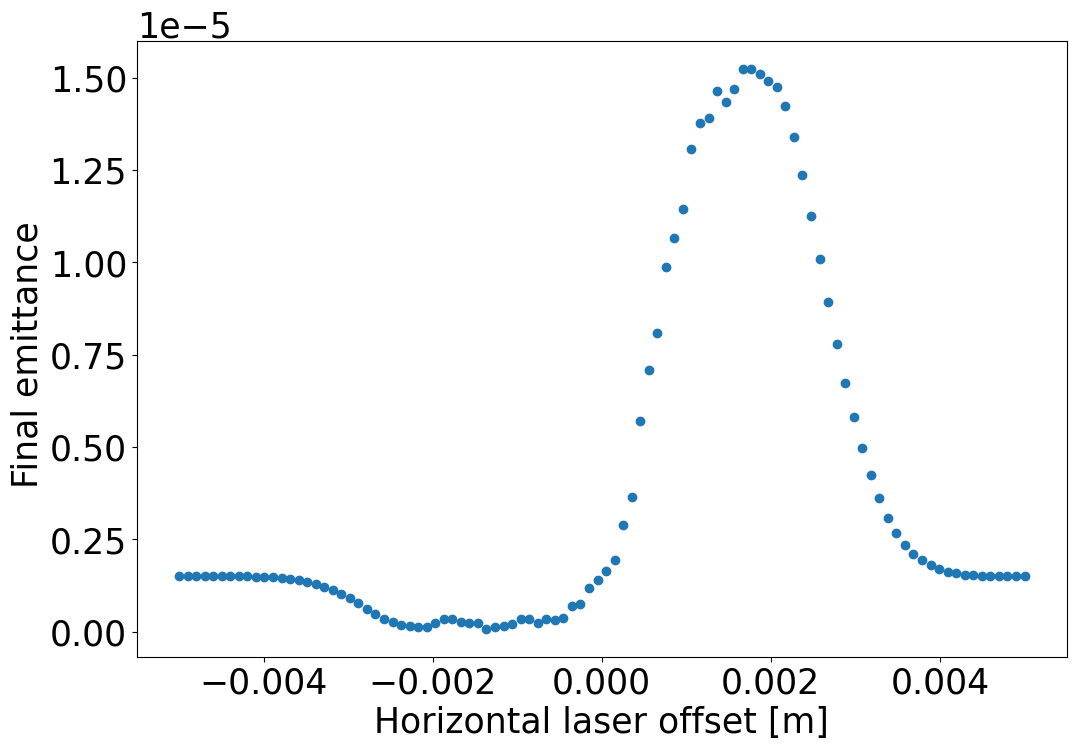

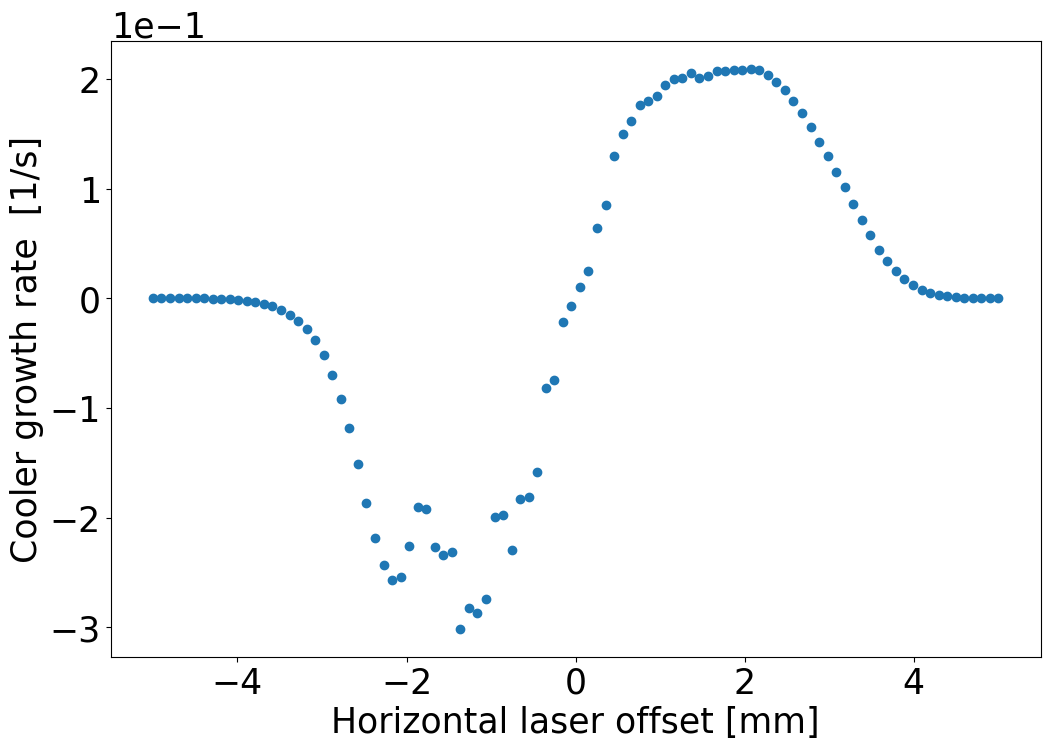

In [10]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(laser_x_list,final_emittance_list)
plt.xlabel('Horizontal laser offset [m]')
plt.ylabel('Final emittance ')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(laser_x_list*1e3,cooler_growth_rates_list)
plt.xlabel('Horizontal laser offset [mm]')
plt.ylabel('Cooler growth rate  [1/s]')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.savefig('Optimal_laser_offset.png',dpi=300)
plt.show()